In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
from sindy_functions import *
from systems import *

In [6]:
def ff(t,x):
    dx=[x[1],
        -9.81]
    return dx

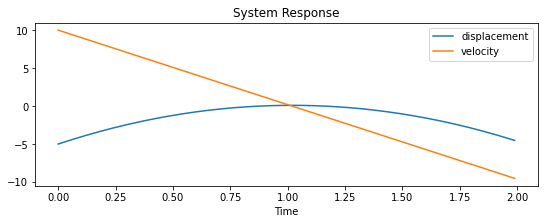

In [43]:
x0=[-5,10]

dt=1e-2
Tf=2
tstamps=np.arange(0,Tf,dt)

Sol=sc.integrate.solve_ivp(ff,[0,Tf],x0,t_eval=tstamps,method='LSODA',max_step=0.01).y
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

plt.figure(figsize=(9, 3))
plt.title('System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='displacement')
plt.plot(tstamps,Sol[1,:],label='velocity')
plt.legend()
plt.show()

[ 5. 10.]


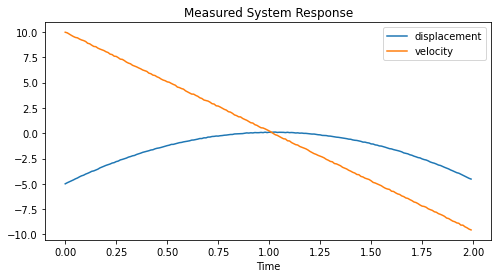

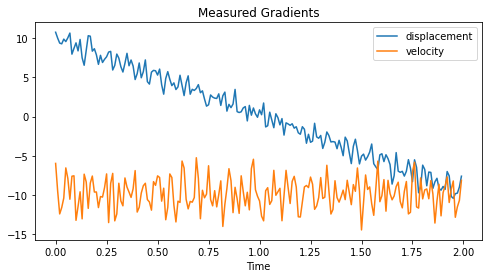

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [45]:
#x, x' normalisation - noise free

nc=np.abs(Sol.T).max(axis=0)
print(nc)
nSol=Sol.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

#noise addition
np.random.seed(0) #seed 0 M4,4 M10
nlevel=0.005
#nSol=np.random.normal(nSol,nlevel/2)
nSol=nSol+np.random.uniform(low=-nlevel,high=nlevel,size=nSol.shape)
#nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
#nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[0]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T
uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

#x, x' normalisation - with noise

#nc=np.abs(uSolm.T).max(axis=0)
#nSol=uSol.T/nc
#nSol=nSol.T
#nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

plt.figure(figsize=(8, 4))
plt.title('Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,uSol[0,:],label='displacement')
plt.plot(tstamps,uSol[1,:],label='velocity')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Measured Gradients')
plt.xlabel('Time')
plt.plot(tstamps,uSoldt[0,:],label='displacement')
plt.plot(tstamps,uSoldt[1,:],label='velocity')
plt.legend()
plt.show()

for ii in range(1,11):
    deg=3
    poly_library=ps.PolynomialLibrary(deg)

    optimizer = ps.STLSQ(threshold=0.1)
    model = ps.SINDy(optimizer=optimizer,feature_library=poly_library).fit(uSol[:,:-ii].T, t=dt, quiet=True)
    #model.print()
    mc=model.coefficients()[:].T
    names=polypool_names(['s','v'],deg)
    dispmymod(mc,['s\'','v\''],names)
    mc=SINDy(polypool(uSol[:,:-ii].T,deg),uSoldt[:,:-ii].T,0.1,reg=0,normalise='auto')
    names=polypool_names(['s','v'],deg)
    dispmymod(mc,['s\'','v\''],names)
    print()

In [48]:
#speed test

In [49]:
import time
t = time.time()
#time.sleep(1)
elapsed = time.time() - t
print(elapsed)

0.0


In [50]:
nlevel=0.005

In [51]:
t = time.time()

for i in tnrange(10000):
    #midpoint=np.average(Sol,axis=1)
    midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
    #midpoint=np.array([0,0])
    Solm=Sol-np.reshape(midpoint,(2,-1))

    #Sol[1]=np.gradient(Sol[0],dt)

    #Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
    #Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

    #x, x' normalisation - noise free

    #midpoint=np.average(Sol,axis=1)
    midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
    Solm=Sol-np.reshape(midpoint,(2,-1))

    nc=np.abs(Solm.T).max(axis=0)
    nSol=Solm.T/nc
    nSol=nSol.T
    nSolnf=np.copy(nSol)
    nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

    #noise addition
    #np.random.seed(0) #seed 0 M4,4 M10
    #nlevel=0.0005
    #nSol=np.random.normal(nSol,nlevel/2)
    nSol=nSol+np.random.uniform(low=-nlevel,high=nlevel,size=nSol.shape)
    #nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
    #nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[0]))

    #implied noisy measurements - unnormalised
    uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
    uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

    #x, x' normalisation - with noise

    #midpoint=np.average(Sol,axis=1)
    midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2*0
    uSolm=uSol-np.reshape(midpoint,(2,-1))*0

    nc=np.abs(uSolm.T).max(axis=0)
    nSol=uSolm.T/nc
    nSol=nSol.T
    nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

    deg=3
    poly_library=ps.PolynomialLibrary(deg)
    optimizer = ps.STLSQ(threshold=0.5)
    model = ps.SINDy(optimizer=optimizer,feature_library=poly_library).fit(uSol[:,:].T, t=dt, quiet=True)
    #model.print()
    mc=model.coefficients()[:].T
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #mc=SINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.1,normalise='auto')
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #print()

elapsed1 = time.time() - t
print(elapsed1)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10000 [00:00<?, ?it/s]

49.332181215286255


In [52]:
t = time.time()

for i in tnrange(10000):
    #midpoint=np.average(Sol,axis=1)
    midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
    #midpoint=np.array([0,0])
    Solm=Sol-np.reshape(midpoint,(2,-1))

    #Sol[1]=np.gradient(Sol[0],dt)

    #Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
    #Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

    #x, x' normalisation - noise free

    #midpoint=np.average(Sol,axis=1)
    midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
    Solm=Sol-np.reshape(midpoint,(2,-1))

    nc=np.abs(Solm.T).max(axis=0)
    nSol=Solm.T/nc
    nSol=nSol.T
    nSolnf=np.copy(nSol)
    nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

    #noise addition
    #np.random.seed(0) #seed 0 M4,4 M10
    #nlevel=0.005
    #nSol=np.random.normal(nSol,nlevel/2)
    nSol=nSol+np.random.uniform(low=-nlevel,high=nlevel,size=nSol.shape)
    #nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
    #nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[0]))

    #implied noisy measurements - unnormalised
    uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
    uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

    #x, x' normalisation - with noise

    #midpoint=np.average(Sol,axis=1)
    midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2*0
    uSolm=uSol-np.reshape(midpoint,(2,-1))*0

    nc=np.abs(uSolm.T).max(axis=0)
    nSol=uSolm.T/nc
    nSol=nSol.T
    nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

    deg=3
    #poly_library=ps.PolynomialLibrary(deg)
    #optimizer = ps.STLSQ(threshold=0.1)
    #model = ps.SINDy(optimizer=optimizer,feature_library=poly_library).fit(uSol[:,:].T, t=dt, quiet=True)
    #model.print()
    #mc=model.coefficients()[:].T
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    mc=SINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.5,normalise='auto')
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #print()

elapsed2 = time.time() - t
print(elapsed2)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10000 [00:00<?, ?it/s]

13.741387367248535


In [53]:
elapsed1/elapsed2

3.5900437049657334

In [54]:
t = time.time()


#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
#midpoint=np.array([0,0])
Solm=Sol-np.reshape(midpoint,(2,-1))

#Sol[1]=np.gradient(Sol[0],dt)

#Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
#Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

#x, x' normalisation - noise free

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
Solm=Sol-np.reshape(midpoint,(2,-1))

nc=np.abs(Solm.T).max(axis=0)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

#noise addition
#np.random.seed(0) #seed 0 M4,4 M10
#nlevel=0.0005
#nSol=np.random.normal(nSol,nlevel/2)
nSol=nSol+np.random.uniform(low=-nlevel,high=nlevel,size=nSol.shape)
#nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
#nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[0]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

#x, x' normalisation - with noise

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2*0
uSolm=uSol-np.reshape(midpoint,(2,-1))*0

nc=np.abs(uSolm.T).max(axis=0)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

deg=3
poly_library=ps.PolynomialLibrary(deg)
optimizer = ps.STLSQ(threshold=0.5)

for i in tnrange(10000):

    model = ps.SINDy(optimizer=optimizer,feature_library=poly_library).fit(uSol[:,:].T, t=dt, quiet=True)
    #model.print()
    mc=model.coefficients()[:].T
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #mc=SINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.1,normalise='auto')
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #print()

elapsed3 = time.time() - t
print(elapsed3)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/10000 [00:00<?, ?it/s]

45.61780524253845


In [55]:
t = time.time()


#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
#midpoint=np.array([0,0])
Solm=Sol-np.reshape(midpoint,(2,-1))

#Sol[1]=np.gradient(Sol[0],dt)

#Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
#Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

#x, x' normalisation - noise free

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2*0
Solm=Sol-np.reshape(midpoint,(2,-1))

nc=np.abs(Solm.T).max(axis=0)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

#noise addition
#np.random.seed(0) #seed 0 M4,4 M10
#nlevel=0.005
#nSol=np.random.normal(nSol,nlevel/2)
nSol=nSol+np.random.uniform(low=-nlevel,high=nlevel,size=nSol.shape)
#nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
#nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[0]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

#x, x' normalisation - with noise

#midpoint=np.average(Sol,axis=1)
midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2*0
uSolm=uSol-np.reshape(midpoint,(2,-1))*0

nc=np.abs(uSolm.T).max(axis=0)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

deg=3
w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,normalise='auto')

for i in tnrange(10000):
    #poly_library=ps.PolynomialLibrary(deg)
    #optimizer = ps.STLSQ(threshold=0.1)
    #model = ps.SINDy(optimizer=optimizer,feature_library=poly_library).fit(uSol[:,:].T, t=dt, quiet=True)
    #model.print()
    #mc=model.coefficients()[:].T
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #mc=SINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.1,normalise='auto')
    mc=post_SINDy(w,rtr,rtqtb,0.5)
    #names=polypool_names(['s','v'],deg)
    #dispmymod(mc,['s\'','v\''],names)
    #print()

elapsed4 = time.time() - t
print(elapsed4)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/10000 [00:00<?, ?it/s]

5.259269952774048


In [56]:
elapsed3/elapsed4

8.673790402882236